In [455]:
# import packages
import os
from xml.etree.ElementInclude import include

import couchdb
import json
from shapely.geometry import Polygon, box
from collections import defaultdict
import nltk
import pandas as pd
import numpy as np

from textblob import TextBlob
import re

from nltk.corpus import stopwords
from nltk.tokenize import TweetTokenizer
from nltk import pos_tag
from nltk.corpus import wordnet
from nltk.stem import WordNetLemmatizer
from nltk.sentiment.vader import SentimentIntensityAnalyzer
from sklearn.feature_selection import f_regression
from empath import Empath

import matplotlib.pyplot as plt
import matplotlib
import seaborn as sns

import ast
import wordcloud

from gensim.models import Phrases
from gensim.corpora.dictionary import Dictionary
from gensim import corpora
from gensim.models.ldamodel import LdaModel

import warnings
warnings.filterwarnings('ignore')

In [456]:
# data loading 
_id = []
user_id = []
location = []
time = []
text = []
rt_cnt = []
like_cnt = []
hashtag = []

_id_before = []
location_before = []
time_before = []
text_before = []


path = ['area-finding/tweepyUserTimeLine/tweet_melbourne0.json',
        'area-finding/tweepyUserTimeLine/tweet_melbourne1.json',
        'area-finding/tweepyUserTimeLine/tweet_melbourne2.json',
        'area-finding/tweepyUserTimeLine/tweet_melbourne3.json',
        'area-finding/tweepyUserTimeLine/tweet_melbourne4.json',
        'area-finding/tweepyUserTimeLine/tweet_melbourne5.json',
        'area-finding/tweepyUserTimeLine/tweet_melbourne6.json',
        'area-finding/tweepyUserTimeLine/tweet_melbourne7.json']

for ele in path:
    f = open(ele)
    line = f.readline()
    while line:
        line_dict = ast.literal_eval(line)

        d = line_dict['created_at'].split()

        if d[1] == 'Jan':
            month = '01'
        elif d[1] == 'Feb':
            month = '02'
        elif d[1] == 'March':
            month = '03'
        elif d[1] == 'Apr':
            month = '04'
        elif d[1] == 'May':
            month = '05'
        elif d[1] == 'Jun':
            month = '06'
        elif d[1] == 'Jul':
            month = '07'
        elif d[1] == 'Aug':
            month = '08'
        elif d[1] == 'Sep':
            month = '09'
        elif d[1] == 'Oct':
            month = '10'
        elif d[1] == 'Nov':
            month = '11'
        elif d[1] == 'Dec':
            month = '12'
        
        if int(d[5]) > 2019:
            _id.append(line_dict['_id'])
            user_id.append(line_dict['user_id'])
            location.append(line_dict['user_place'])
            text.append(line_dict['text'])
            time.append(d[5] + '-' + month)
            rt_cnt.append(line_dict['retweet_count'])
            like_cnt.append(line_dict['favorite_count'])
            hashtag.append(line_dict['hashtags'])
        
        if int(d[5]) > 2016 and int(d[5]) < 2020:
            _id_before.append(line_dict['_id'])
            location_before.append(line_dict['user_place'])
            text_before.append(line_dict['text'])
            time_before.append(d[5] + '-' + month)

        line = f.readline()

    f.close()

In [457]:
data = pd.DataFrame()

data['id'] = _id
data['user_id'] = user_id
data['location'] = location
data['text'] = text
data['time'] = time
data['rt'] = rt_cnt
data['like'] = like_cnt
data['hashtag'] = hashtag

data_before = pd.DataFrame()

data_before['id'] = _id_before
data_before['location'] = location_before
data_before['text'] = text_before
data_before['time'] = time_before

In [458]:
data = data.dropna()
data_before = data_before.dropna()

In [459]:
print(data.shape)
print(data_before.shape)

(7687901, 8)
(2546570, 4)


In [460]:
# classify if lacation is one of Melbourne, Sydney, Brisbane or Adelaide
if_city = []
for idx,val in enumerate(data['location']):
    val = val.lower()
    if ('melbourne' in val) or ('sydney' in val) or ('brisbane' in val) or ('adelaide' in val):
        if_city.append(True)
    else: 
        if_city.append(False)

if_city_before = []
for idx,val in enumerate(data_before['location']):
    val = val.lower()
    if ('melbourne' in val) or ('sydney' in val) or ('brisbane' in val) or ('adelaide' in val):
        if_city_before.append(True)
    else: 
        if_city_before.append(False)

In [461]:
data['if_city'] = if_city
data = data[data['if_city'] == True]

data_before['if_city'] = if_city_before
data_before = data_before[data_before['if_city'] == True]

In [462]:
print(data.shape)
print(data_before.shape)


(4600387, 9)
(1720898, 5)


In [463]:
# define punctuations and emojis that might be contained in tweets

punctuation = '!"$%&\'()*+,-./:;<=>?[\\]^_`{|}~•@'

emoji = re.compile("["  
    u"\U0001F600-\U0001F64F" 
    u"\U0001F300-\U0001F5FF" 
    u"\U0001F680-\U0001F6FF"  
    u"\U0001F1E0-\U0001F1FF"  
    u"\U00002500-\U00002BEF"  
    u"\U00002702-\U000027B0"
    u"\U00002702-\U000027B0"
    u"\U000024C2-\U0001F251"
    u"\U0001f926-\U0001f937"
    u"\U00010000-\U0010ffff"
    u"\u2640-\u2642" 
    u"\u2600-\u2B55"
    u"\u200d"
    u"\u23cf"
    u"\u23e9"
    u"\u231a"
    u"\ufe0f"  
    u"\u3030"
                  "]+", re.UNICODE)

In [464]:
# tweets text cleaning

def clean_text(text):

    #tokenizer = TweetTokenizer(r'\w+')

    text  = text.replace('\n'," ")
    text = re.sub('-'," ",text)
    text = re.sub(r"\d+/\d+/\d+", "", text) # remove date
    text = re.sub(r"[0-2]?[0-9]:[0-6][0-9]", "", text) # remove time
    text = re.sub("http\S+", "", text)   # remove http links
    text = re.sub(r"bit.ly/\S+", '', text) # remove bit links
    text = text.strip('[link]') # remove other links
    text = text.lower()
    text = re.sub('(@[A-Za-z]+[A-Za-z0-9-_]+)', '', text)
    text = re.sub('(RT\s@[A-Za-z]+[A-Za-z0-9-_]+)', '', text)
    text = re.sub(r"[\w]+@[\.\w]+", "", text) # remove email address
    text = re.sub(r"/[a-zA-Z]*[:\//\]*[A-Za-z0-9\-_]+\.+[A-Za-z0-9\.\/%&=\?\-_]+/i", "", text)
    text = re.sub(emoji, '', text) # remove emoji
    text = re.sub('[' + punctuation + ']+', ' ', text) # remove punctuation
    #text = tokenizer.tokenize(text)

    pure_text = ''
    for letter in text:
        if letter.isalpha() or letter ==' ':
            pure_text += letter
    text = ' '.join(word for word in pure_text.split() if len(word)>3)

    #lemmatizer = WordNetLemmatizer()
    #text = [[lemmatizer.lemmatize(word) for word in pure_text.split()]]

    return text

cleaned_text = data['text'].apply(lambda x :clean_text(x))
cleaned_text_before = data_before['text'].apply(lambda x :clean_text(x))

In [465]:
data['cleaned_text'] = cleaned_text
data_before['cleaned_text'] = cleaned_text_before

In [466]:
# mental health keywords loading
with open('area-finding/mental_health_keywords_400.txt') as f:
    contents = f.read()
    mental_keywords = contents.split(',')


In [467]:
# filter mental health related tweets from dataset
def mental_health(dataset):

    if_mental = []

    for text in dataset['cleaned_text']:
        cnt = 0
        for word in mental_keywords:
            if word in text:
                cnt += 1
        if cnt > 0:
            if_mental.append(True)
        else:
            if_mental.append(False)
    
    return if_mental

data['if_mental'] = mental_health(data)
data_before['if_mental'] = mental_health(data_before)

In [468]:
# Data on mental health in four cities
data_mental = data[data['if_mental'] == True]
data_before_mental = data_before[data_before['if_mental'] == True]

In [469]:
print(data_mental.shape)
print(data_before_mental.shape)

(332524, 11)
(120089, 7)


# Sentiment Analysis

In [470]:
# Generate sentiment polarity and subjectivity score for each tweet
def sentiment_analysis(dataset):

    sentiment_polarity = []
    sentiment_subjectivity = []

    for val in dataset['cleaned_text']:
        val = TextBlob(val)
        sentiment_polarity.append(val.sentiment.polarity)
        sentiment_subjectivity.append(val.sentiment.subjectivity)

    return sentiment_polarity, sentiment_subjectivity

data_mental['sentiment_polarity'] = sentiment_analysis(data_mental)[0]
data_mental['sentiment_subjectivity'] = sentiment_analysis(data_mental)[1]
data_before_mental['sentiment_polarity'] = sentiment_analysis(data_before_mental)[0]
data_before_mental['sentiment_subjectivity'] = sentiment_analysis(data_before_mental)[1]

In [471]:
# Remove neutral tweets
data_mental = data_mental[data_mental['sentiment_polarity'] != 0]
data_before_mental = data_before_mental[data_before_mental['sentiment_polarity'] != 0]

In [472]:
print(data_mental.shape)
print(data_before_mental.shape)

(197449, 13)
(71494, 9)


In [473]:
# Distinguish four cities
def city_classifier(dataset):

    mel_idx = []
    syd_idx = []
    bris_idx = []
    ald_idx = []

    for idx,val in enumerate(dataset['location']):
        val = val.lower()
        if 'melbourne' in val:
            mel_idx.append(idx)
        if 'sydney' in val:
            syd_idx.append(idx)
        if 'brisbane' in val:
            bris_idx.append(idx)
        if 'adelaide' in val:
            ald_idx.append(idx)
    
    return mel_idx, syd_idx, bris_idx, ald_idx


In [474]:
# Distinguishing Cities
melbourne_mental = data_mental.iloc[city_classifier(data_mental)[0]]
sydney_mental = data_mental.iloc[city_classifier(data_mental)[1]]
brisbane_mental = data_mental.iloc[city_classifier(data_mental)[2]]
adelaide_mental = data_mental.iloc[city_classifier(data_mental)[3]]

melbourne_before_mental = data_before_mental.iloc[city_classifier(data_before_mental)[0]]
sydney_before_mental = data_before_mental.iloc[city_classifier(data_before_mental)[1]]
brisbane_before_mental = data_before_mental.iloc[city_classifier(data_before_mental)[2]]
adelaide_before_mental = data_before_mental.iloc[city_classifier(data_before_mental)[3]]

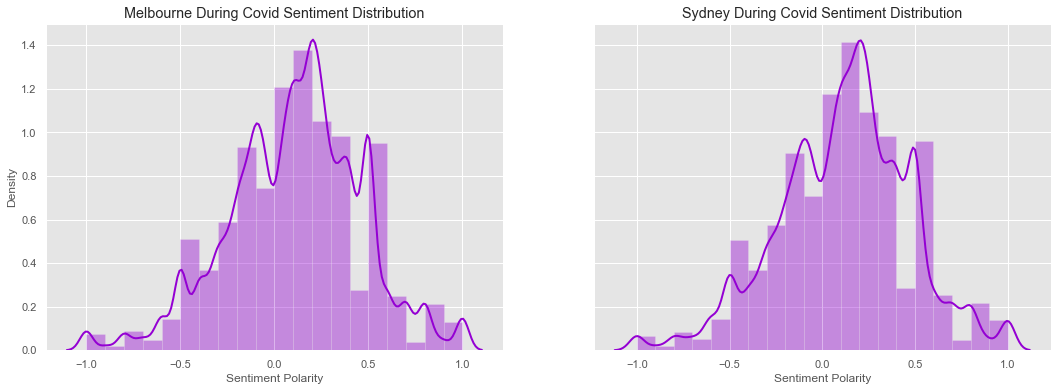

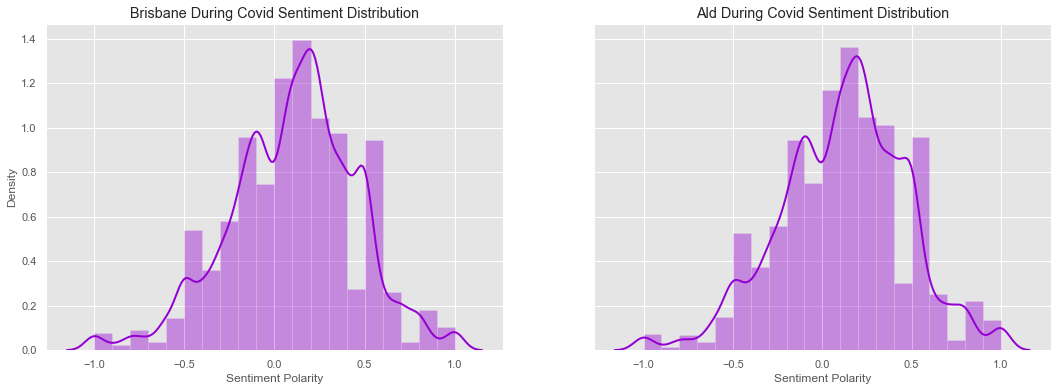

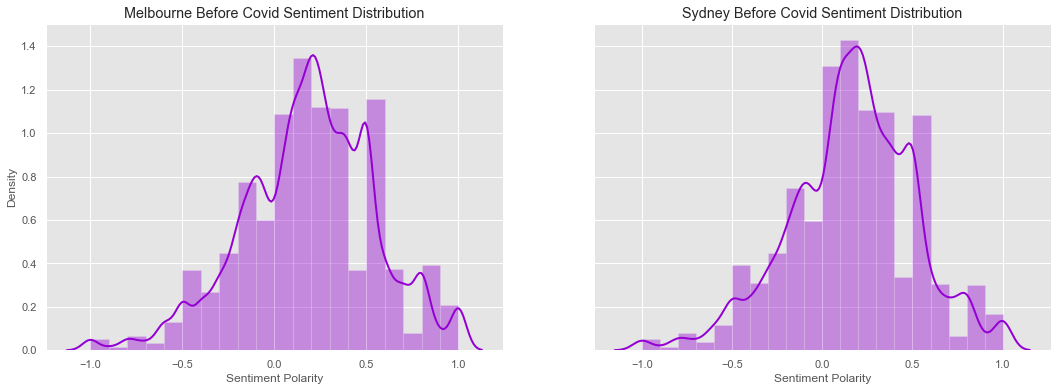

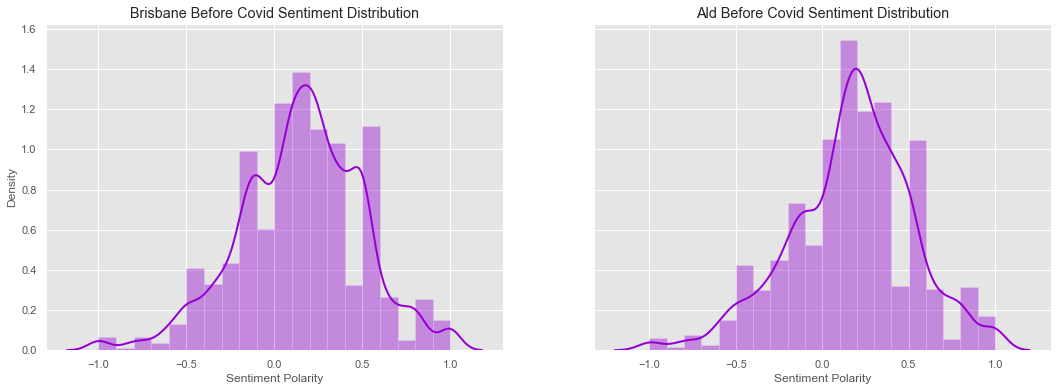

In [475]:
# Plot sentiment polarity for four cities (within Covid period and before Covid period)
def sentiment_plot(city_1, city_2, title_list):
    fig, ax = plt.subplots(ncols=2, nrows=1, figsize=(18, 6), sharey=True)
    n_bins = 20
    sns.distplot(city_1["sentiment_polarity"], ax=ax[0], bins = n_bins, color = "darkviolet", kde_kws = {"linewidth": 2})
    sns.distplot(city_2["sentiment_polarity"], ax=ax[1], bins = n_bins, color = "darkviolet", kde_kws = {"linewidth": 2})

    for idx, subplot in enumerate(ax):
        subplot.set_xlabel('Sentiment Polarity')
        subplot.set_ylabel('Density')
        subplot.set_title(title_list[idx])

title_list = ['Melbourne During Covid Sentiment Distribution', 'Sydney During Covid Sentiment Distribution']
sentiment_plot(melbourne_mental, sydney_mental, title_list)

title_list = ['Brisbane During Covid Sentiment Distribution', 'Ald During Covid Sentiment Distribution']
sentiment_plot(brisbane_mental, adelaide_mental, title_list)

title_list = ['Melbourne Before Covid Sentiment Distribution', 'Sydney Before Covid Sentiment Distribution']
sentiment_plot(melbourne_before_mental, sydney_before_mental, title_list)

title_list = ['Brisbane Before Covid Sentiment Distribution', 'Ald Before Covid Sentiment Distribution']
sentiment_plot(brisbane_before_mental, adelaide_before_mental, title_list)

In [397]:
'''
def sentiment_plot(city_1, city_2, title_list):
    fig, ax = plt.subplots(ncols=2, nrows=1, figsize=(18, 6), sharey=True)
    n_bins = 20
    sns.distplot(city_1["sentiment_subjectivity"], ax=ax[0], bins = n_bins, color = "darkviolet", kde_kws = {"linewidth": 2})
    sns.distplot(city_2["sentiment_subjectivity"], ax=ax[1], bins = n_bins, color = "darkviolet", kde_kws = {"linewidth": 2})
    #sns.distplot(city_3["sentiment_polarity"], ax=ax[2], bins = n_bins, color = "darkviolet", kde_kws = {"linewidth": 2})
    #sns.distplot(city_4["sentiment_polarity"], ax=ax[3], bins = n_bins, color = "darkviolet", kde_kws = {"linewidth": 2})

    for idx, subplot in enumerate(ax):
        #ax.tick_params(axis = "both", labelsize = 14)
        subplot.set_xlabel('Sentiment Subjectivity')
        subplot.set_ylabel('Density')
        subplot.set_title(title_list[idx])
        #subplot.set_xlabel('Sentiment Polarity')

title_list = ['Melbourne Sentiment Distribution', 'Sydney Sentiment Distribution']#, 'Brisbane Sentiment Distribution', 'Ald Sentiment Distribution']
sentiment_plot(melbourne_mental, sydney_mental, title_list)# brisbane_mental, ald_mental, title_list)

title_list = ['Brisbane Sentiment Distribution', 'Ald Sentiment Distribution']
sentiment_plot(brisbane_mental, adelaide_mental, title_list)
'''

'\ndef sentiment_plot(city_1, city_2, title_list):\n    fig, ax = plt.subplots(ncols=2, nrows=1, figsize=(18, 6), sharey=True)\n    n_bins = 20\n    sns.distplot(city_1["sentiment_subjectivity"], ax=ax[0], bins = n_bins, color = "darkviolet", kde_kws = {"linewidth": 2})\n    sns.distplot(city_2["sentiment_subjectivity"], ax=ax[1], bins = n_bins, color = "darkviolet", kde_kws = {"linewidth": 2})\n    #sns.distplot(city_3["sentiment_polarity"], ax=ax[2], bins = n_bins, color = "darkviolet", kde_kws = {"linewidth": 2})\n    #sns.distplot(city_4["sentiment_polarity"], ax=ax[3], bins = n_bins, color = "darkviolet", kde_kws = {"linewidth": 2})\n\n    for idx, subplot in enumerate(ax):\n        #ax.tick_params(axis = "both", labelsize = 14)\n        subplot.set_xlabel(\'Sentiment Subjectivity\')\n        subplot.set_ylabel(\'Density\')\n        subplot.set_title(title_list[idx])\n        #subplot.set_xlabel(\'Sentiment Polarity\')\n\ntitle_list = [\'Melbourne Sentiment Distribution\', \'Sydne

In [476]:
print(melbourne_mental.shape)
print(sydney_mental.shape)
print(brisbane_mental.shape)
print(adelaide_mental.shape)
print('\n')
print(melbourne_before_mental.shape)
print(sydney_before_mental.shape)
print(brisbane_before_mental.shape)
print(adelaide_before_mental.shape)

(112781, 13)
(55481, 13)
(17359, 13)
(12444, 13)


(43927, 9)
(16664, 9)
(6804, 9)
(4184, 9)


# Observing the relation between Covid-19 and the number of mental health related tweets

In [477]:
# Creat a monthly time frame from 2020 to present
start = '2020-01'
end = '2022-05'
t = pd.date_range(start=start, end=end, freq = 'M').tolist()
time_frame = []
for i in t:
    i = str(i)[:-12]
    time_frame.append(i)

In [478]:
melbourne_mental_cnt = melbourne_mental.sort_values(['time'], ascending=True).groupby('time')['time'].count()

In [479]:
# Load data of PCR comfirmed cases
data_covid = pd.read_csv('NCOV_COVID_Cases_by_LGA_20220511.csv')

time_covid = []

for val in data_covid['diagnosis_date']:
    val = val[0:7]
    time_covid.append(val)

data_covid['time'] = time_covid

In [480]:
data_covid_cnt = data_covid.sort_values(['time'], ascending=True).groupby('time')['time'].count()

<function matplotlib.pyplot.show(close=None, block=None)>

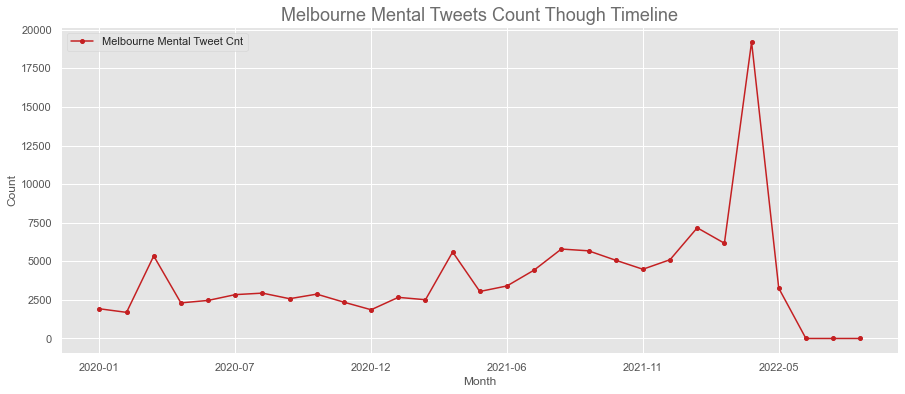

In [481]:
plt.style.use('ggplot')
fig = plt.figure(figsize=(15, 6))
color_1 = '#6D6D6D'

melbourne_mental_cnt.plot(
    color = '#C42022',
    marker = 'o', markersize = 4,
    label = 'Melbourne Mental Tweet Cnt'
)

plt.title('Melbourne Mental Tweets Count Though Timeline', color = color_1, fontsize = 18)
plt.xlabel('Month')
plt.ylabel('Count')
plt.legend()
plt.show

<function matplotlib.pyplot.show(close=None, block=None)>

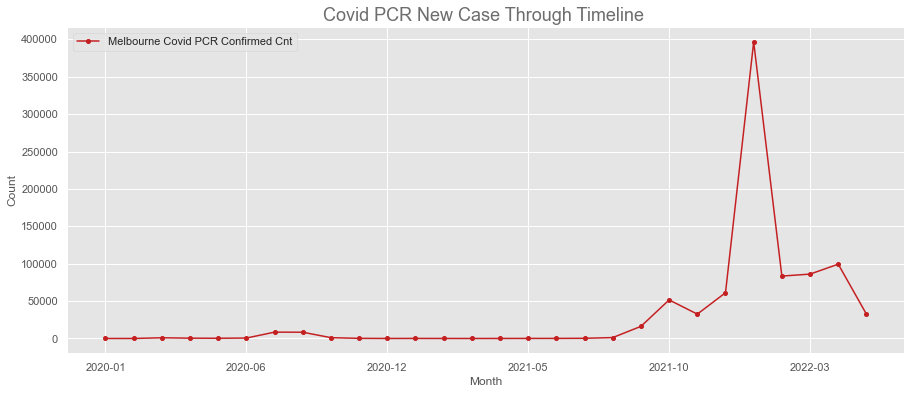

In [482]:
plt.style.use('ggplot')
fig = plt.figure(figsize=(15, 6))
color_1 = '#6D6D6D'

data_covid_cnt.plot(
    color = '#C42022',
    marker = 'o', markersize = 4,
    label = 'Melbourne Covid PCR Confirmed Cnt'
)

plt.title('Covid PCR New Case Through Timeline ', color = color_1, fontsize = 18)
plt.xlabel('Month')
plt.ylabel('Count')
plt.legend()
plt.show

# Word Cloud

In [483]:
stoplist = ['very', 'ourselves', 'am', 'doesn', 'through', 'me', 'against', 'up', 'just', 'her', 'ours', 
            'couldn', 'because', 'is', 'isn', 'it', 'only', 'in', 'such', 'too', 'mustn', 'under', 'their', 
            'if', 'to', 'my', 'himself', 'after', 'why', 'while', 'can', 'each', 'itself', 'his', 'all', 'once', 
            'herself', 'more', 'our', 'they', 'hasn', 'on', 'ma', 'them', 'its', 'where', 'did', 'll', 'you', 
            'didn', 'nor', 'as', 'now', 'before', 'those', 'yours', 'from', 'who', 'was', 'm', 'been', 'will', 
            'into', 'same', 'how', 'some', 'of', 'out', 'with', 's', 'being', 't', 'mightn', 'she', 'again', 'be', 
            'by', 'shan', 'have', 'yourselves', 'needn', 'and', 'are', 'o', 'these', 'further', 'most', 'yourself', 
            'having', 'aren', 'here', 'he', 'were', 'but', 'this', 'myself', 'own', 'we', 'so', 'i', 'does', 'both', 
            'when', 'between', 'd', 'had', 'the', 'y', 'has', 'down', 'off', 'than', 'haven', 'whom', 'wouldn', 
            'should', 've', 'over', 'themselves', 'few', 'then', 'hadn', 'what', 'until', 'won', 'no', 'about', 
            'any', 'that', 'for', 'shouldn', 'don', 'do', 'there', 'doing', 'an', 'or', 'ain', 'hers', 'wasn', 
            'weren', 'above', 'a', 'at', 'your', 'theirs', 'below', 'other', 'not', 're', 'him', 'during', 'which',
            'im', 'dont', 'havent', 'like', 'one', 'get', 'first', 'time', 'many', 'would', 'today', 'think', 'want',
            'little', 'much', 'take', 'need', 'make']

In [484]:
def takeCnt(x):
    return x[1]

def generate_word_list(dataset):
    word_text = [[word for word in doc.lower().split() if word not in stoplist] for doc in dataset['cleaned_text']]
    word_str = ''
    for ele in word_text:
        for val in ele:
            word_str += val + ' '
    
    return word_str


def word_cnt(word_str):

    words = word_str.split()
    word_cnt = {}

    for word in words:
        word_cnt[word] = word_cnt.get(word, 0) + 1

    items = list(word_cnt.items())
    items.sort(key = takeCnt, reverse = True)

    for i in range(10):
        key, value = items[i]
        print('{0:<10}{1:>5}'.format(key, value))


def word_cnt_plt(word_str):

    words = word_str.split()
    word_cnt = {}

    for word in words:
        word_cnt[word] = word_cnt.get(word, 0) + 1

    items = list(word_cnt.items())
    items.sort(key = takeCnt, reverse = True)

    return items

In [485]:
# Melbourne calculating word frequency
print('Melbourne word count: ')
word_cnt(generate_word_list(melbourne_mental))

# Sydney calculating word frequency
print('Sydney word count: ')
word_cnt(generate_word_list(sydney_mental))

# Brisbane calculating word frequency
print('Brisbane word count: ')
word_cnt(generate_word_list(brisbane_mental))

# Adelaide calculating word frequency
print('Ald word count: ')
word_cnt(generate_word_list(adelaide_mental))

Melbourne word count: 
media      9085
people     6138
health     3841
good       3811
social     3680
covid      3446
great      3401
mental     3121
event      3065
right      2620
Sydney word count: 
media      4240
people     2655
covid      1901
good       1807
social     1785
event      1704
great      1674
health     1658
australia  1414
confirmed  1335
Brisbane word count: 
media      1535
people      899
good        668
covid       536
love        530
health      503
social      499
great       474
morrison    455
really      412
Ald word count: 
media       895
people      617
good        451
great       387
covid       376
event       368
health      337
australia   332
social      327
adelaide    296


In [486]:
def generate_word_cloud(dataset):
    txt = generate_word_list(dataset)
    font_path = os.environ.get('FONT_PATH', '/Library/Fonts/Times New Roman.ttf')
    w = wordcloud.WordCloud(font_path = font_path, width = 800, height = 600, max_words = 45, font_step = 3)
    w.generate(txt)
    w.to_file('wordcloud.png')

    print('word cloud generated successfully!')

In [487]:
generate_word_cloud(melbourne_mental)

word cloud generated successfully!


In [488]:
generate_word_cloud(sydney_mental)

word cloud generated successfully!


In [489]:
generate_word_cloud(brisbane_mental)

word cloud generated successfully!


In [490]:
generate_word_cloud(adelaide_mental)

word cloud generated successfully!


# Hashtag Analysis

### Pandamic Period (2020-01 to present)

In [491]:
if_hashtag = []
for idx,val in enumerate(melbourne_mental['hashtag']):
    if len(val) > 0:
        if_hashtag.append(True)
    else:
        if_hashtag.append(False)

melbourne_mental['if_hashtag'] = if_hashtag
melbourne_mental_hashtag = melbourne_mental[melbourne_mental['if_hashtag'] == True]

In [492]:
def generate_hashtag_list(dataset):
    word_str = ''
    for ele in dataset['hashtag']:
        for val in ele:
            word_str += val + ' '
    
    return word_str

In [493]:
word_cnt(generate_hashtag_list(melbourne_mental_hashtag))

auspol      571
SurvivorAU  456
COVID19     323
Oscars      184
Supernatural  143
memories    142
BREAKING    139
mentalhealth  120
coronavirus  107
Tokyo2020   105


<function matplotlib.pyplot.show(close=None, block=None)>

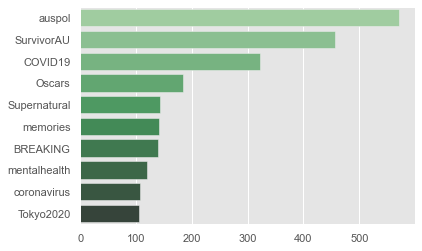

In [494]:
x = []
y = []
for val in word_cnt_plt(generate_hashtag_list(melbourne_mental_hashtag))[0:10]:
    key, value = val
    x.append(key)
    y.append(value)

sns.barplot(y, x, palette='Greens_d')
plt.show

### First Wave (2020-03 to 2020-05)

In [495]:
melbourne_mental_hashtag_w1 = melbourne_mental_hashtag.loc[(melbourne_mental_hashtag['time'] >= '2020-03') & (melbourne_mental_hashtag['time'] <= '2020-05')] 
melbourne_mental_hashtag_w1 = melbourne_mental_hashtag_w1.reset_index(drop = True)

In [496]:
def hashtag_attention(dataset):

    hashtag_score = {}

    for idx, val in enumerate(dataset['hashtag']):
        for hashtag in val:
            hashtag_score[hashtag] = hashtag_score.get(hashtag, 0) + int(dataset['rt'][idx])*5 + int(dataset['like'][idx])

    score = list(hashtag_score.items())
    score.sort(key = takeCnt, reverse = True)

    return score

<function matplotlib.pyplot.show(close=None, block=None)>

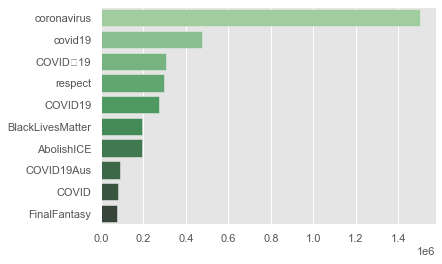

In [498]:
x_1 = []
y_1 = []
for val in hashtag_attention(melbourne_mental_hashtag_w1)[0:10]:
    key, value = val
    x_1.append(key)
    y_1.append(value)

sns.barplot(y_1, x_1, palette='Greens_d')
plt.show

### Second Wave (2020-06 to 2020-10)

In [499]:
melbourne_mental_hashtag_w2 = melbourne_mental_hashtag.loc[(melbourne_mental_hashtag['time'] >= '2020-06') & (melbourne_mental_hashtag['time'] <= '2020-10')] 
melbourne_mental_hashtag_w2 = melbourne_mental_hashtag_w2.reset_index(drop = True)

<function matplotlib.pyplot.show(close=None, block=None)>

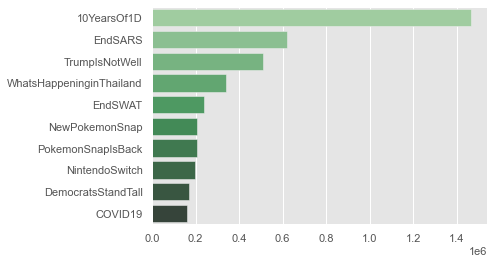

In [500]:
x_2 = []
y_2 = []
for val in hashtag_attention(melbourne_mental_hashtag_w2)[0:10]:
    key, value = val
    x_2.append(key)
    y_2.append(value)

sns.barplot(y_2, x_2, palette='Greens_d')
plt.show

### Third Wave (2021-07 to 2021-12)

In [501]:
melbourne_mental_hashtag_w3 = melbourne_mental_hashtag.loc[(melbourne_mental_hashtag['time'] >= '2021-07') & (melbourne_mental_hashtag['time'] <= '2021-12')] 
melbourne_mental_hashtag_w3 = melbourne_mental_hashtag_w3.reset_index(drop = True)

<function matplotlib.pyplot.show(close=None, block=None)>

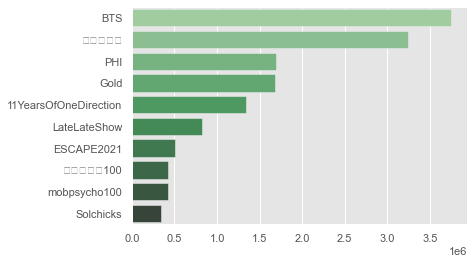

In [502]:
x_3 = []
y_3 = []
for val in hashtag_attention(melbourne_mental_hashtag_w3)[0:10]:
    key, value = val
    x_3.append(key)
    y_3.append(value)

sns.barplot(y_3, x_3, palette='Greens_d')
plt.show

### Fourth Wave (2022-01 to present)

In [503]:
melbourne_mental_hashtag_w4 = melbourne_mental_hashtag.loc[(melbourne_mental_hashtag['time'] >= '2022-01')] 
melbourne_mental_hashtag_w4 = melbourne_mental_hashtag_w4.reset_index(drop = True)

<function matplotlib.pyplot.show(close=None, block=None)>

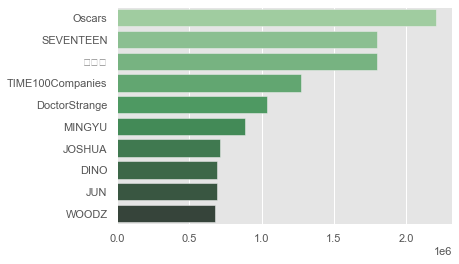

In [504]:
x_4 = []
y_4 = []
for val in hashtag_attention(melbourne_mental_hashtag_w4)[0:10]:
    key, value = val
    x_4.append(key)
    y_4.append(value)

sns.barplot(y_4, x_4, palette='Greens_d')
plt.show

### Combine Hashtag Plots

In [505]:
x = x_1 + x_2 + x_3 + x_4
y = y_1 + y_2 + y_3 + y_4
flag = ['Wave 1']*10 + ['Wave 2']*10 + ['Wave 3']*10 + ['Wave 4']*10

In [506]:
hashtag_waves = pd.DataFrame()
hashtag_waves['x'] = x
hashtag_waves['y'] = y
hashtag_waves['flag'] = flag

In [507]:
def hashtag_plot(wave1, wave2, title_list):
  fig, axes = plt.subplots(2, 1, figsize=(18, 8))
  axes = axes.flatten()

  sns.barplot(x=wave1['y'], y=wave1['x'], palette='Greens_d',ax = axes[0])
  sns.barplot(x=wave2['y'], y=wave2['x'], palette='Greens_d', ax = axes[1])
  axes[0].set_title(title_list[0])
  axes[1].set_title(title_list[1])

  axes[0].set_ylabel("")
  axes[1].set_ylabel("")
  axes[1].set_xlabel('Hashtag Attention')
  axes[0].set_xlabel('')

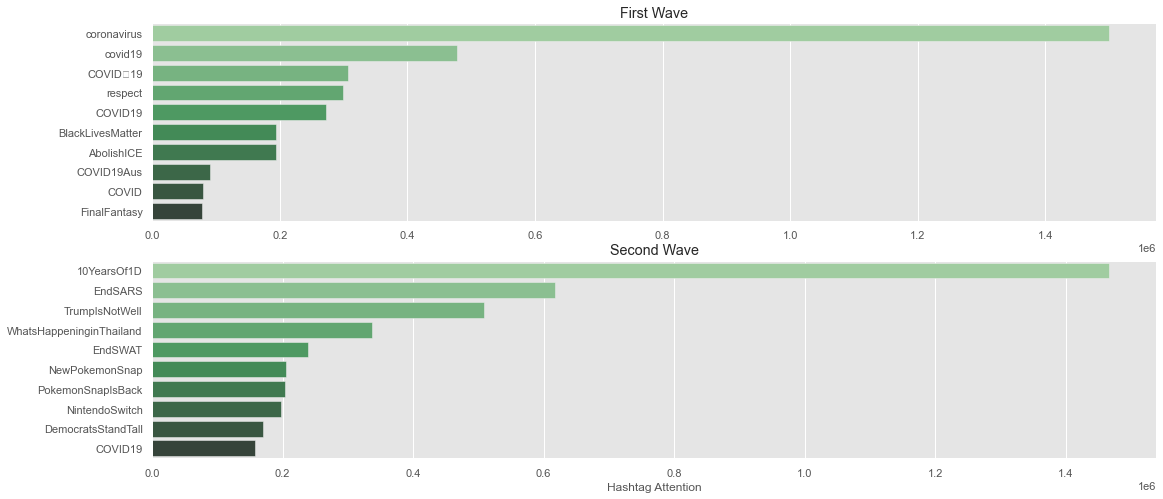

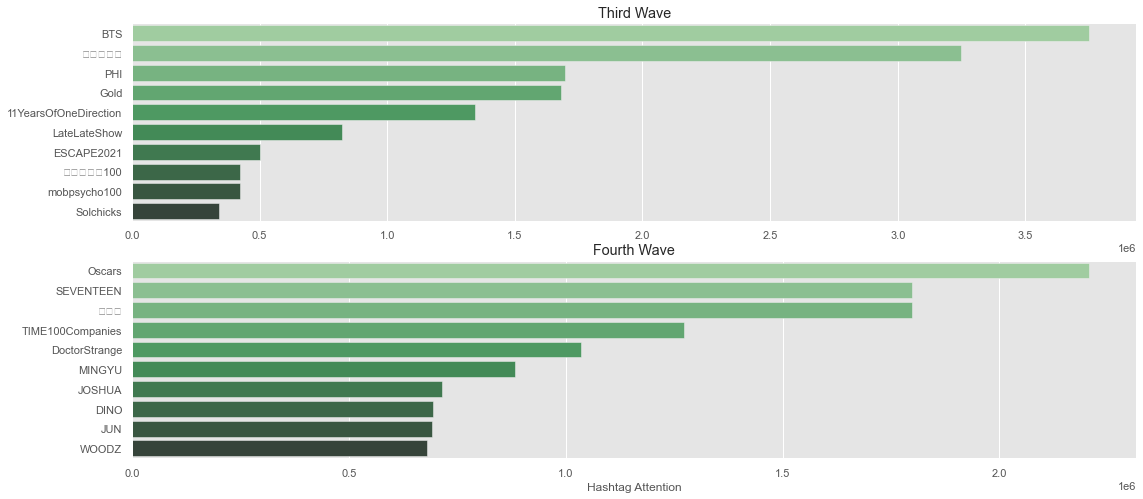

In [508]:
hashtag_plot(hashtag_waves[hashtag_waves['flag'] == 'Wave 1'], hashtag_waves[hashtag_waves['flag'] == 'Wave 2'], ['First Wave', 'Second Wave'])
hashtag_plot(hashtag_waves[hashtag_waves['flag'] == 'Wave 3'], hashtag_waves[hashtag_waves['flag'] == 'Wave 4'], ['Third Wave', 'Fourth Wave'])

# Topic Modeling

In [509]:
new_stopword = nltk.corpus.stopwords.words('english')
repeated_words = ['ever', 'start', 'pre', 'amp', '&amp', 'may', 'and', 'when', 'what', 'who', 'why', 'how',
                  'this', 'your', 'mine', 'their', 'her', 'his', 'that']

for ele in repeated_words:
    new_stopword.append(ele)

In [510]:
tweets = melbourne_mental['cleaned_text'].apply(lambda x: ' '.join([word for word in x.split() if word not in new_stopword]))

tokenizer = TweetTokenizer(r'\w+')
tweets = [tokenizer.tokenize(tweet) for tweet in tweets]

lemmatizer = WordNetLemmatizer()
tweets = [[lemmatizer.lemmatize(token) for token in tweet] for tweet in tweets]

In [511]:
bigram = Phrases(tweets, min_count = 10)
trigram = Phrases(bigram[tweets])

for i in range(len(tweets)):
    for val in bigram[tweets[i]]:
        if '_' in val:
            tweets[i].append(val)
    for val in trigram[tweets[i]]:
        if '_' in val:
            tweets[i].append(val)

dictionary = Dictionary(tweets)
dictionary.filter_extremes(no_below=10, no_above=0.2)

corpus = [dictionary.doc2bow(tweet) for tweet in tweets]

In [513]:
topic_num = 5

temp = dictionary[0]
id2word = dictionary.id2token

lda_model = LdaModel(corpus = corpus, id2word = id2word, chunksize = len(melbourne_mental)/5,
                     alpha = 'auto', eta = 'auto', iterations = 20, num_topics = topic_num, 
                     passes = 20, eval_every = 1, random_state = np.random.RandomState(100))

print(lda_model.print_topics())

[(0, '0.238*"video_game" + 0.158*"pokémon" + 0.085*"first" + 0.084*"know" + 0.083*"want" + 0.082*"game" + 0.081*"video" + 0.079*"became" + 0.079*"trainer" + 0.002*"havent_seen"'), (1, '0.020*"medium" + 0.009*"climate_change" + 0.008*"news" + 0.007*"murdoch_medium" + 0.007*"getting_worse" + 0.006*"mainstream_medium" + 0.006*"good_news" + 0.006*"next_week" + 0.006*"climate" + 0.006*"recovery"'), (2, '0.026*"social_medium" + 0.023*"medium" + 0.011*"social" + 0.009*"people" + 0.004*"think" + 0.004*"right" + 0.004*"dont" + 0.004*"need" + 0.004*"would" + 0.004*"many"'), (3, '0.031*"mental_health" + 0.016*"health" + 0.013*"mental" + 0.009*"scott_morrison" + 0.008*"people" + 0.007*"morrison" + 0.007*"covid" + 0.004*"medical" + 0.004*"scott" + 0.004*"prime_minister"'), (4, '0.008*"event" + 0.008*"like" + 0.007*"time" + 0.007*"good" + 0.006*"year" + 0.006*"great" + 0.006*"memory" + 0.005*"love" + 0.005*"havent" + 0.005*"today"')]


# Suburb Analysis (2020-01 to present)

In [514]:
user_id = []
user_sub = []

f = open('area-finding/authorListAdd.json')
line = f.readline()
line = line[1:-1].split('},')
for val in line:
    val = val + '}'
    sub = int(val[val.find('suburb": ') + 9:val.find('}')])

    if sub > 0:
        user_id.append(val[val.find('_id": ') + 6:val.find(', "coor')])
        user_sub.append(sub)

f.close()

In [515]:
melbourne_user_info = pd.DataFrame()
melbourne_user_info['user_id'] = user_id
melbourne_user_info['user_suburb'] = user_sub

In [516]:
melbourne_mental_sub = melbourne_mental.merge(melbourne_user_info, on = 'user_id')

In [517]:
# Total number of sentiment-related tweets per suburb, number of positive tweets, number of negative tweets (during the epidemic)
suburb_mental_cnt = melbourne_mental_sub.groupby('user_suburb')['user_suburb'].count()
suburb_mental_positive_cnt = melbourne_mental_sub[melbourne_mental_sub['sentiment_polarity'] > 0].groupby('user_suburb')['user_suburb'].count()
suburb_mental_negative_cnt = melbourne_mental_sub[melbourne_mental_sub['sentiment_polarity'] < 0].groupby('user_suburb')['user_suburb'].count()

In [518]:
# Calculate the average number of retweets and likes of sentiment-related tweets, positive tweets, negative tweets per suburb on average (during the epidemic)
suburb_mental_rt_sum = (melbourne_mental_sub.groupby('user_suburb')['rt'].sum()) / suburb_mental_cnt
suburb_mental_rt_pos_sum = (melbourne_mental_sub[melbourne_mental_sub['sentiment_polarity'] > 0].groupby('user_suburb')['rt'].sum()) / suburb_mental_cnt
suburb_mental_rt_neg_sum = (melbourne_mental_sub[melbourne_mental_sub['sentiment_polarity'] < 0].groupby('user_suburb')['rt'].sum()) / suburb_mental_cnt

suburb_mental_like_sum = (melbourne_mental_sub.groupby('user_suburb')['like'].sum()) / suburb_mental_cnt
suburb_mental_like_pos_sum = (melbourne_mental_sub[melbourne_mental_sub['sentiment_polarity'] > 0].groupby('user_suburb')['like'].sum()) / suburb_mental_cnt
suburb_mental_like_neg_sum = (melbourne_mental_sub[melbourne_mental_sub['sentiment_polarity'] < 0].groupby('user_suburb')['like'].sum()) / suburb_mental_cnt

# Export data to json for front end 

In [519]:
# Export mental health related tweets of four cities
data_mental_js = data_mental.drop(columns = ['if_city', 'if_mental'], axis = 1).to_json(r'Mental.json', orient = 'records')

In [ ]:
'''
# 数据输出为json
melbourne_mental_js = melbourne_mental.drop(columns = ['if_city', 'if_mental'], axis = 1).to_json(r'Melbourne_mental.json', orient = 'records')
sydney_mental_js = sydney_mental.drop(columns = ['if_city', 'if_mental'], axis = 1).to_json(r'Sydney_mental.json', orient = 'records')
brisbane_mental_js = brisbane_mental.drop(columns = ['if_city', 'if_mental'], axis = 1).to_json(r'Brisbane_mental.json', orient = 'records')
adelaide_mental_js = adelaide_mental.drop(columns = ['if_city', 'if_mental'], axis = 1).to_json(r'Adelaide_mental.json', orient = 'records')

melbourne_before_mental_js = melbourne_before_mental.drop(columns = ['if_city', 'if_mental'], axis = 1).to_json(r'Melbourne_before_mental.json', orient = 'records')
sydney_before_mental_js = sydney_before_mental.drop(columns = ['if_city', 'if_mental'], axis = 1).to_json(r'Sydney_before_mental.json', orient = 'records')
brisbane_mental_js = brisbane_before_mental.drop(columns = ['if_city', 'if_mental'], axis = 1).to_json(r'Brisbane_before_mental.json', orient = 'records')
adelaide_mental_js = adelaide_before_mental.drop(columns = ['if_city', 'if_mental'], axis = 1).to_json(r'Adelaide_before_mental.json', orient = 'records')
'''

In [520]:
# Top 100 hashtags in Melbourne in epidemic period
hashtag_top_100 = word_cnt_plt(generate_hashtag_list(melbourne_mental_hashtag))[0:100]
hashtag_top_100_df = pd.DataFrame(hashtag_top_100) 
hashtag_top_100_df.columns = ['hashtag', 'cnt']
hashtag_top_100_js = hashtag_top_100_df.to_json(r'Melbourne_hashtag_top_100.json', orient = 'records')

In [521]:
# Top 100 hashtags in Melboure during the first wave
hashtag_w1_df = pd.DataFrame(hashtag_attention(melbourne_mental_hashtag_w1)[0:100])
hashtag_w1_df.columns = ['hashtag', 'cnt']
hashtag_w1_js = hashtag_w1_df.to_json(r'Melbourne_wave_1_hashtag.json', orient = 'records')

In [522]:
# Top 100 hashtags in Melboure during the second wave
hashtag_w2_df = pd.DataFrame(hashtag_attention(melbourne_mental_hashtag_w2)[0:100])
hashtag_w2_df.columns = ['hashtag', 'cnt']
hashtag_w2_js = hashtag_w2_df.to_json(r'Melbourne_wave_2_hashtag.json', orient = 'records')

In [523]:
# Top 100 hashtags in Melboure during the third wave
hashtag_w3_df = pd.DataFrame(hashtag_attention(melbourne_mental_hashtag_w3)[0:100])
hashtag_w3_df.columns = ['hashtag', 'cnt']
hashtag_w3_js = hashtag_w3_df.to_json(r'Melbourne_wave_3_hashtag.json', orient = 'records')

In [524]:
# Top 100 hashtags in Melboure during the fourth wave
hashtag_w4_df = pd.DataFrame(hashtag_attention(melbourne_mental_hashtag_w4)[0:100])
hashtag_w4_df.columns = ['hashtag', 'cnt']
hashtag_w4_js = hashtag_w4_df.to_json(r'Melbourne_wave_4_hashtag.json', orient = 'records')

In [525]:
# Mental related data with suburb info in Melbourne
melbourne_mental_sub_js = melbourne_mental_sub.drop(columns = ['if_city', 'if_mental', 'if_hashtag'], axis = 1).to_json(r'Melbourne_mental_suburb.json', orient = 'records')

In [526]:
# # Total number of sentiment-related tweets per suburb, number of positive tweets, number of negative tweets (during the epidemic)
suburb_mental_cnt_js = suburb_mental_cnt.reset_index(name = 'cnt').to_json(r'Suburb_mental_count.json', orient = 'records')
suburb_mental_pos_cnt_js = suburb_mental_cnt.reset_index(name = 'cnt').to_json(r'Suburb_mental_positive_count.json', orient = 'records')
suburb_mental_neg_cnt_js = suburb_mental_cnt.reset_index(name = 'cnt').to_json(r'Suburb_mental_nagetive_count.json', orient = 'records')

In [527]:
# Calculate the average number of retweets of sentiment-related tweets, positive tweets, negative tweets per suburb on average (during the epidemic)
suburb_mental_rt_js = suburb_mental_rt_sum.reset_index(name = 'cnt').to_json(r'Suburb_mental_rt_avg.json', orient = 'records')
suburb_mental_rt_pos_js = suburb_mental_rt_pos_sum.reset_index(name = 'cnt').to_json(r'Suburb_mental_rt_pos_avg.json', orient = 'records')
suburb_mental_rt_neg_js = suburb_mental_rt_neg_sum.reset_index(name = 'cnt').to_json(r'Suburb_mental_rt_neg_avg.json', orient = 'records')

In [528]:
# Calculate the average number of likes of sentiment-related tweets, positive tweets, negative tweets per suburb on average (during the epidemic)
suburb_mental_like_js = suburb_mental_like_sum.reset_index(name = 'cnt').to_json(r'Suburb_mental_like_avg.json', orient = 'records')
suburb_mental_like_pos_js = suburb_mental_like_pos_sum.reset_index(name = 'cnt').to_json(r'Suburb_mental_like_pos_avg.json', orient = 'records')
suburb_mental_like_neg_js = suburb_mental_like_neg_sum.reset_index(name = 'cnt').to_json(r'Suburb_mental_like_neg_avg.json', orient = 'records')